# Reinforcement Learning - Donkey Kong

## Imports

In [1]:
import gymnasium as gym
import gym
import random
import time


import numpy as np
import matplotlib.pyplot as plt
from collections import deque


import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import deque

RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

## Enviroment Setup

In [2]:
env = gym.make('ALE/DonkeyKong-v5', render_mode='rgb_array')
height, width, channels = env.observation_space.shape
actions = env.action_space

Action Space: Discrete(18)
State space: Box(0, 255, (210, 160, 3), uint8)


C:\Users\lowie\.virtualenvs\Project-46Jsvre_\Lib\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


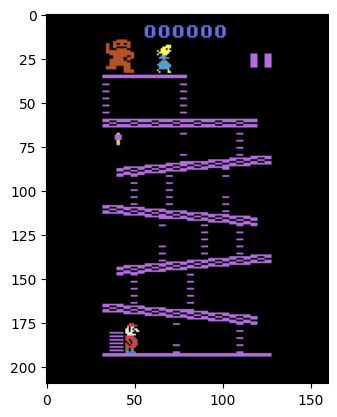

In [3]:
print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))
env.reset()
img = plt.imshow(env.render())

In [4]:
action_meanings = env.unwrapped.get_action_meanings()
num_actions = len(action_meanings)
print(f"Action Meanings: {action_meanings}, Total Actions: {num_actions}")


Action Meanings: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE'], Total Actions: 18


Randomly running a game

In [5]:
import gym
from gym.wrappers import RecordVideo


directory = './video_random_DK'
env = RecordVideo(gym.make('ALE/DonkeyKong-v5', render_mode="rgb_array"),
                  video_folder = directory)


epochs, rewards = 0, 0
state = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
    rewards  += reward
    epochs += 1
print(f"Number of steps: {epochs}")



C:\Users\lowie\.virtualenvs\Project-46Jsvre_\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\lowie\OneDrive - Hogeschool West-Vlaanderen\Documenten\Howest\Howest jaar 2\S2\Reinfocement Learning\Project\video_random_DK folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
C:\Users\lowie\.virtualenvs\Project-46Jsvre_\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video C:\Users\lowie\OneDrive - Hogeschool West-Vlaanderen\Documenten\Howest\Howest jaar 2\S2\Reinfocement Learning\Project\video_random_DK\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\lowie\OneDrive - Hogeschool West-Vlaanderen\Documenten\Howest\Howest jaar 2\S2\Reinfocement Learning\Project\video_random_DK\rl-video-episode-0.mp4


Moviepy - Done !
Moviepy - video ready C:\Users\lowie\OneDrive - Hogeschool West-Vlaanderen\Documenten\Howest\Howest jaar 2\S2\Reinfocement Learning\Project\video_random_DK\rl-video-episode-0.mp4
Number of steps: 753


The average after 100 games

In [6]:
Steps = []
env = gym.make('CartPole-v1')
for episode in range(100):
    n_steps_episode = 0
    total_training_rewards = 0
    observation = env.reset()[0]
    done = False
    while not done:
        action = env.action_space.sample()
        new_observation, reward, done, truncated, info = env.step(action)
        total_training_rewards += reward
        observation = new_observation

        n_steps_episode += 1.

    Steps.append(n_steps_episode)

np.mean(Steps)

C:\Users\lowie\.virtualenvs\Project-46Jsvre_\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


23.04

In [7]:
def plot_res(values, title=''):
    ''' Plot the reward curve and histogram of results over time.'''

    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')

    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(200, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

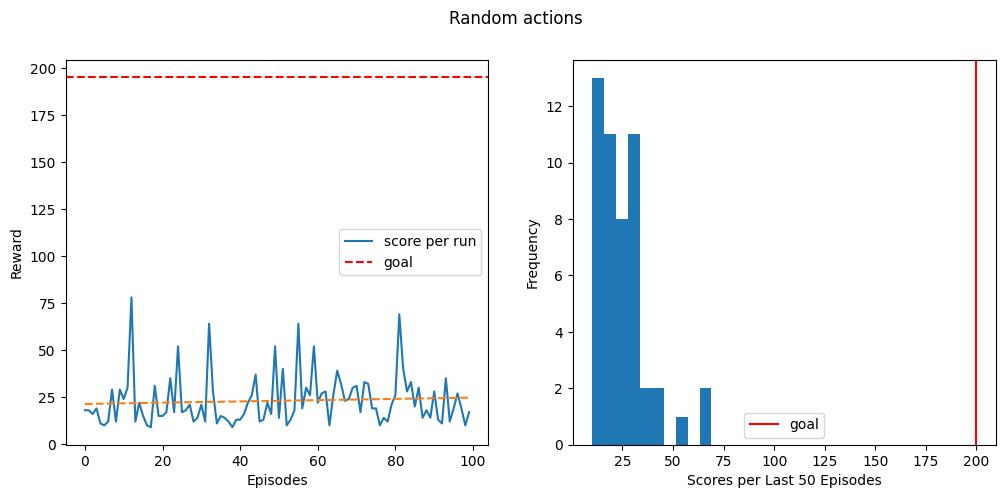

In [8]:
plot_res(Steps,'Random actions')

## Deep Q learning

In [9]:
# An episode a full game
# train_episodes = 150
# test_episodes = 100
train_episodes = 75
test_episodes = 35

In [10]:
epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.01       # we will decline epsilon with steps of 0.01


In [11]:
def agent(state_shape, action_shape):
    learning_rate = 0.01
    init = tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    model.add(keras.layers.Dense(24, input_shape=state_shape, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model



In [12]:
# Main prediction Model (updated every 4 steps)
model = agent(env.observation_space.shape, env.action_space.n)
# Target Model (updated every 100 steps)
target_model = agent(env.observation_space.shape, env.action_space.n)

# Set the weights of the target model to be equal to the weights of the prediction model
target_model.set_weights(model.get_weights())

# Initialize the replay_memory
replay_memory = deque(maxlen=50_000)


C:\Users\lowie\.virtualenvs\Project-46Jsvre_\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:

def train(env, replay_memory, model, target_model, done):
    # We define the learning rate and discount factor
    learning_rate = 0.9 # Learning rate
    discount_factor = 0.8

    # We will only start training the model, once we have a replay memory of at least 1000 steps.
    MIN_REPLAY_SIZE = 1000
    # Therefore, if we have less than 1000, we will skip the training (by using return in the function)
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return



    # We will train our model on 500 random steps from the replay memory each time
    batch_size = 500
    mini_batch = random.sample(replay_memory, batch_size)

    ## We need to define our predictor (X) and outcome (Y) to be able to train the model.  
    # Note that this environment uses 'observation' to refer to the 'state'
    # It is important to realize that in the replay_memory, we will store the different steps as 
    # [observation, action, reward, new_observation, done]

    # First, we transform or selected batch into readable states for the model (so, we select the first element [0] from the replay memory: the 'observation')
    current_states = np.array([transition[0] for transition in mini_batch])
    # Then, we predict the current Q-values, using the prediction network 
    current_qs_list = model.predict(current_states,verbose=0)
    # Then we extract the next state that the agent will end up in , so the fourth elemenent [3]
    new_current_states = np.array([transition[3] for transition in mini_batch])
    # We predict the q-value of the next state by using the target model
    future_qs_list = target_model.predict(new_current_states,verbose=0)


    # Define 2 empty vectors for the X and Y-values
    X = []
    Y = []

    #  Calculate what the maximum q-value is for the next step (to be able to update the q-value), as long as the episode is not done
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        # We update the q-value, using the bellman-equation
        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        # Store the current state in the X-vector, to be used as predictor
        X.append(observation)
        # Store the updated q-value in the Y-vector to be used as the outcome
        Y.append(current_qs)

    ## Finally, train the model
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)


In [14]:
# Define empty vectors to store the predictors and outcomes and the number of steps in one episode
X = []
y = []
Steps = []

# We will need to count how many steps has passed to be ably to update the main and target model 
steps_to_update_target_model = 0

# We will train our agent for a set number of episodes
for episode in range(train_episodes):
    # Set the number of steps (and rewards) for the episode at 0 to start (we will add 1 after each step)
    n_steps_episode = 0
    total_training_rewards = 0
    # Set the state ('observation') at the beginning of a random episode
    observation = env.reset()[0]
    # We start with a game that is not done
    done = False
    # As long as the episode is not done, we will keep playing the game
    while not done:
        # for each step, add 1 to the counter keeping track when to update the models
        steps_to_update_target_model += 1

        # Choose a random number to act out the epsilon greedy stragety
        random_number = np.random.rand()
        if random_number <= epsilon:
            # Explore (use random action) when the number is smaller than epsilon
            action = env.action_space.sample()

        else:
            # Or exploit (choose the best known action) when it is larger
            # Transform the state into the right format for the deep learning model
            observation_reshaped = observation.reshape([1, observation.shape[0]])
            # predict the q-values of all possible actions using the main model
            predicted = model.predict(observation_reshaped,verbose=0).flatten()
            # choose the action based on the predicted q-values
            action = np.argmax(predicted)
            # Store the results of this action
        new_observation, reward, done, truncated, info = env.step(action)
        total_training_rewards += reward
        # Add the step to the replay memory (from which will be sampled to train the model)
        replay_memory.append([observation, action, reward, new_observation, done])

        # Update the Main Network using the Bellman Equation -> here we call the trainingsfunction we defined above
        # We only update our model every 4 steps
        if steps_to_update_target_model % 4 == 0 or done:
            train(env, replay_memory, model, target_model, done)

        # Set the new state to the currect state to be able to perform the next step
        observation = new_observation

        # Count the step you just took
        n_steps_episode += 1

        # At the end of the episode: print the number of steps for that episode and store it in the Steps-vector
        if done:
            print('{} Total training rewards: {} after n steps = {}'.format(episode, total_training_rewards, n_steps_episode))
            Steps.append(n_steps_episode)

            # If 100 steps have passed, copy the network weights of the main model to the target model
            if steps_to_update_target_model >= 100:
                #print('Copying main network weights to the target network weights')
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break
        # Adjust epsilon after an episonde is done
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
env.close()



0 Total training rewards: 15.0 after n steps = 15
1 Total training rewards: 16.0 after n steps = 16
2 Total training rewards: 30.0 after n steps = 30
3 Total training rewards: 33.0 after n steps = 33
4 Total training rewards: 24.0 after n steps = 24
5 Total training rewards: 16.0 after n steps = 16
6 Total training rewards: 45.0 after n steps = 45
7 Total training rewards: 10.0 after n steps = 10
8 Total training rewards: 15.0 after n steps = 15
9 Total training rewards: 11.0 after n steps = 11
10 Total training rewards: 12.0 after n steps = 12
11 Total training rewards: 24.0 after n steps = 24
12 Total training rewards: 21.0 after n steps = 21
13 Total training rewards: 17.0 after n steps = 17
14 Total training rewards: 23.0 after n steps = 23
15 Total training rewards: 13.0 after n steps = 13
16 Total training rewards: 13.0 after n steps = 13
17 Total training rewards: 10.0 after n steps = 10
18 Total training rewards: 32.0 after n steps = 32
19 Total training rewards: 8.0 after n st

In [15]:
#pip install h5py==2.10.0 --force-reinstall

In [16]:
import joblib
model.save('cartpole_deepQ.keras')
# load the model
from tensorflow.keras.models import load_model
model = load_model('cartpole_deepQ.keras')



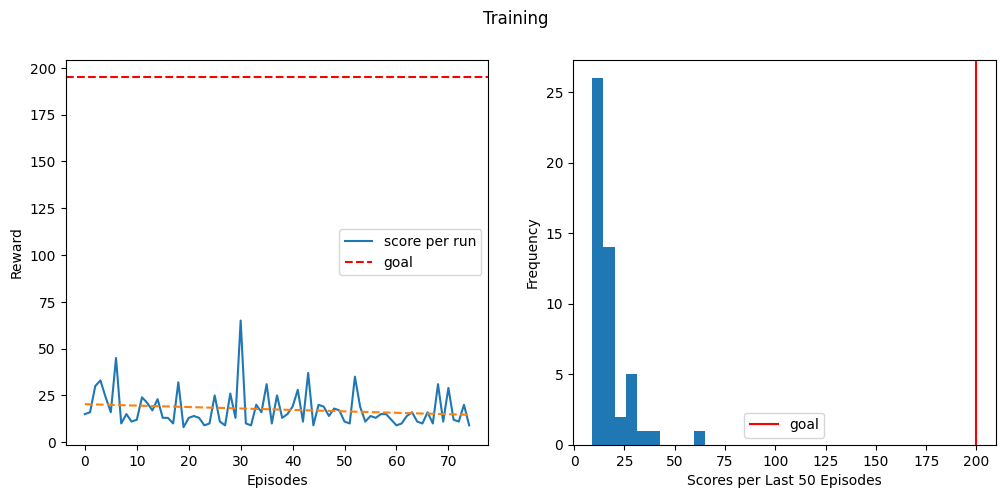

In [17]:
plot_res(Steps,'Training')

In [ ]:
def evaluate_model(env, model, episodes=10):
    total_rewards = []
    for _ in range(episodes):
        state_tuple = env.reset()  # Get the tuple from reset
        state = state_tuple[0]      # Extract the state from the tuple
        episode_reward = 0
        done = False
        while not done:
            # Use the trained model to select actions
            action = np.argmax(model.predict(state.reshape(1, -1)))

            # Perform the action in the environment
            step_result = env.step(action)

            if isinstance(step_result, tuple) and len(step_result) >= 4:
                next_state, reward, done, info = step_result[:4]
            elif isinstance(step_result, tuple) and len(step_result) == 3:
                next_state, reward, done = step_result
                info = {}
            else:
                raise ValueError("Unexpected return format from env.step()")

            state = next_state  # Update the state for the next iteration
            episode_reward += reward

        total_rewards.append(episode_reward)

    return total_rewards

# Evaluate the trained model
eval_rewards = evaluate_model(env, model)
average_reward = np.mean(eval_rewards)
print(f"Average reward over {len(eval_rewards)} episodes: {average_reward}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
'''
epochs, rewards = 0, 0
done = False

while not done:
    # Assuming 'observation' is a 3D array (height, width, channels)
    observation_reshaped = observation.reshape((1,) + observation.shape)

    # Predict action from model
    predicted = model.predict(observation_reshaped)
    action = np.argmax(predicted)

    # Take action in the environment
    new_observation, reward, done, truncated, info = env.step(action)

    # Update observation to the new state
    observation = new_observation

    # Update total rewards and epochs
    rewards += reward
    epochs += 1

print(f"Number of steps: {epochs}")
'''

In [ ]:
'''
import gym
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from PIL import Image

# Define the CNN model with appropriate input shape
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(210, 160, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # Adjust output size based on your model's requirements
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Steps = []
env = gym.make('ALE/DonkeyKong-v5', render_mode="rgb_array")

# Define video writer for saving gameplay as a video
video_filename = 'gameplay_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_out = cv2.VideoWriter(video_filename, fourcc, 60.0, (160, 210))

for episode in range(10):
    n_steps_episode = 0
    total_training_rewards = 0

    observation_tuple = env.reset()  # Reset environment and get initial observation tuple
    observation = observation_tuple[0]  # Extract the image data from the tuple
    done = False

    while not done:
        # Preprocess observation
        resized_observation = np.array(Image.fromarray(observation).resize((160, 210)))  # Resize image
        processed_input = resized_observation.reshape(1, 210, 160, 3)  # Reshape to match model input

        # Predict action using the model
        predicted = model.predict(processed_input)
        action = np.argmax(predicted)

        # Take action in the environment and get the step result
        step_result = env.step(action)

        # Check the format of step_result
        if isinstance(step_result, tuple):
            if len(step_result) == 2:  # Assuming (new_observation, reward)
                observation, reward = step_result
                done = False  # Continue the episode
            elif len(step_result) == 4:  # Assuming (new_observation, reward, done, info)
                observation, reward, done, info = step_result
            else:
                raise ValueError(f"Unexpected step result format: {step_result}")
        else:
            raise ValueError(f"Unexpected step result type: {type(step_result)}")

        n_steps_episode += 1
        total_training_rewards += reward

        # Render and save the current frame to the video
        frame_rgb = cv2.cvtColor(observation, cv2.COLOR_RGB2BGR)
        video_out.write(frame_rgb)

    print(f'Episode {episode}: Total steps = {n_steps_episode}, Total rewards = {total_training_rewards}')
    Steps.append(n_steps_episode)

# Release video writer and close environment
video_out.release()
env.close()

print(f'Gameplay video saved as: {video_filename}')
'''

In [ ]:
'''
plot_res(Steps,'Test')
'''